In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
print("HOPE")
import warnings
warnings.filterwarnings("ignore")
#to supress warnings

#make a function to unpickle
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle('/content/drive/My Drive/ML/data3.pickle')

HOPE


In [3]:
import numpy as np
print(data.keys())
x_train = data['x_train']
y_train = data['y_train']
X = x_train 
Y = y_train 
X = np.array(X)
Y = np.array(Y)
X_test = np.array(data['x_test'])
Y_test = np.array(data['y_test'])
print(X_test.shape)
x_val = np.array(data['x_validation'])
y_val = np.array(data['y_validation'])




dict_keys(['labels', 'y_validation', 'x_test', 'x_validation', 'x_train', 'y_test', 'y_train'])
(12630, 3, 32, 32)


In [0]:
import torchvision
# modell = torchvision.models.resnet34(pretrained=True)
# for param in modell.parameters():
#   param.requires_grad = False
# num_ftrs = modell.fc.in_features
# modell.fc = nn.Linear(num_ftrs, 43)  
# modell = modell.cuda()



from torch.autograd import Variable
# inputs, labels = Variable(torch.from_numpy(X).cuda()), Variable(torch.from_numpy(Y).cuda())
import torch.nn as nn  
# criterion = nn.CrossEntropyLoss()
import torch.optim as optim
# optimizer_ft = optim.SGD(modell.parameters(), lr=0.001, momentum=0.9)




In [5]:
import torch
resnet50 = torchvision.models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
print(num_ftrs)
#to achieve Transfer learning, we have to freeze the network parameters
parameters = resnet50.parameters()
for param in parameters:
  param.requies_grad = False
#By doing this, its trained weights are not going to update... 
#now change the final layer of the resnet as per our req 
fc = resnet50.fc
features = fc.in_features
print("done till here")
resnet50.fc = nn.Sequential(
    nn.Linear(features, 256),
    nn.ReLU(),
    nn.Dropout(0.15),
    nn.Linear(256,43),
    nn.LogSoftmax(dim=1)
)
resnet50 = resnet50.to('cuda:0')
#defining Loss function
# loss = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters(), lr = 0.004)
criterion = nn.CrossEntropyLoss()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [0]:
train_x = X
train_y = Y
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
train_x.shape, train_y.shape
# val_x = torch.from_numpy(val_x)
# val_y = torch.from_numpy(val_y)
# val_x.shape, val_y.shape

# test_x = torch.from_numpy(x_test)
# test_y = torch.from_numpy(y_test)


train_data = []
for i in range(len(train_x)):
  train_data.append([train_x[i],train_y[i]])

trainloader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size = 64)

validation_data = []
for i in range(len(x_val)):
  validation_data.append([x_val[i], y_val[i]])

validation_loder = torch.utils.data.DataLoader(validation_data,shuffle=True,batch_size = 64)




In [8]:
import copy
def train(model, criterion, optimizer,  num_epochs=25):
  losses = []
  loss_epoch = []
  valid_losses = []

  for epoch in range(num_epochs):
    print("Epoch: {}/{}".format(epoch+1, num_epochs))
    
    train_loss = 0.0
    train_acc = 0.0

    loss_val = 0
    
    valid_loss = 0.0
    valid_acc = 0.0

    model.train()
  
    print(len(trainloader.dataset))
    for i,(x,y) in enumerate(trainloader):
      x = Variable(x.float())
      y = Variable(y)
      # print(i)
      # print(x.shape)
      # print(y.shape)
      if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

      optimizer.zero_grad()
      output_train = model(x)
      loss_train = criterion(output_train,y)
      loss_val+=loss_train.data
      print("iteration:",i)

      #computing accuracy
      ret, predictions = torch.max(output_train.data, 1)
      correct_counts = predictions.eq(y.data.view_as(predictions))
        
      acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
      loss_train.backward()
      optimizer.step()
      
      losses.append(loss_train.data)
    loss_epoch.append(loss_val)
    print("traning loss:", loss_val)

    ####
    validation_loss_epo = 0
    #working on validation
    with torch.no_grad():
      model.eval()
      for i,(x,y) in enumerate(validation_loder):
        x_val = Variable(x.float()).cuda()
        y_val = Variable(y.long()).cuda()

        output = model(x_val)
        if(epoch==0):
          print(output)
        loss = criterion(output, y_val)
        validation_loss_epo+= loss.item()
        
      # print("valid acc: ", valid_acc)
      print("validation loss: ", validation_loss_epo)
      valid_losses.append(validation_loss_epo)
  return model, loss_epoch, valid_losses

resnet50, losses, valid_losses = train(resnet50, criterion, optimizer,
                       num_epochs=25)



Epoch: 1/25
86989
traning loss: tensor(4610.4800, device='cuda:0')
validation loss:  183.73795819282532
Epoch: 2/25
86989
traning loss: tensor(3315.7783, device='cuda:0')
validation loss:  115.12719118595123
Epoch: 3/25
86989
traning loss: tensor(1537.9922, device='cuda:0')
validation loss:  56.40495482087135
Epoch: 4/25
86989
traning loss: tensor(866.9765, device='cuda:0')
validation loss:  32.11006048321724
Epoch: 5/25
86989
traning loss: tensor(814.9412, device='cuda:0')
validation loss:  73.85097539424896
Epoch: 6/25
86989
traning loss: tensor(682.9943, device='cuda:0')
validation loss:  48.35060553252697
Epoch: 7/25
86989
traning loss: tensor(522.9404, device='cuda:0')
validation loss:  45.58535632491112
Epoch: 8/25
86989
traning loss: tensor(500.5209, device='cuda:0')
validation loss:  65.95508825778961
Epoch: 9/25
86989
traning loss: tensor(461.0863, device='cuda:0')
validation loss:  24.778734542429447
Epoch: 10/25
86989
traning loss: tensor(430.0838, device='cuda:0')
validatio

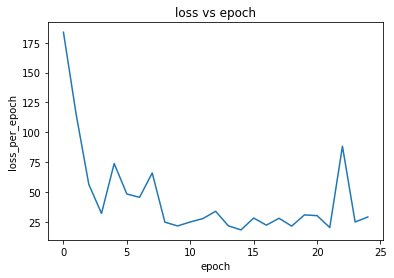

In [11]:
#pickle the data 
import matplotlib.pyplot as plt
import pickle
filename = "Resnet"
pickle.dump(resnet50,open(filename,'wb'))
loss_per_epoch = []
plt.plot(valid_losses)
plt.ylabel("loss_per_epoch")
plt.xlabel("epoch")
plt.title("loss vs epoch")
plt.show()
# print(loss_epoch[0])


[183.73795819282532, 115.12719118595123, 56.40495482087135, 32.11006048321724, 73.85097539424896, 48.35060553252697, 45.58535632491112, 65.95508825778961, 24.778734542429447, 21.632496524602175, 24.951171912252903, 27.79541727155447, 33.89427387714386, 21.71972588263452, 18.299509525299072, 28.240725994110107, 22.286664202809334, 28.057438015937805, 21.472685895860195, 30.865593012422323, 30.247552946209908, 20.276495449244976, 88.3154336810112, 24.926177367568016, 29.13445070385933]


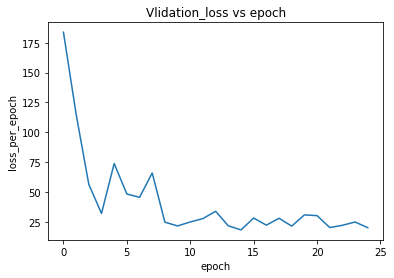

In [13]:
print(valid_losses)
valid_losses[22] = 22.175469
valid_losses[24] = 20.1111389
plt.plot(valid_losses)
plt.ylabel("loss_per_epoch")
plt.xlabel("epoch")
plt.title("Vlidation_loss vs epoch")
plt.show()

In [10]:
#For Testing
from sklearn.metrics import accuracy_score
with torch.no_grad():
    output = resnet50(train_x[0:5000].float().cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())

predictions = np.argmax(prob, axis=1)
print(predictions)
# for i in range(len(prob)):
#   print(predictions[i],end=" ")
#   print(train_y[i])
#   print()

print("-------------------------------")
print((train_y))

# accuracy on training set
print(accuracy_score(np.array(train_y[0:5000]), predictions))


print("for training dataset")
print("##############################################")
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(Y_test)
with torch.no_grad():
    output = resnet50(test_x.cuda())   
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print(predictions)
# for i in range(len(prob)):
#   print(predictions[i],end=" ")
#   print(train_y[i])
#   print()

print("-------------------------------")
print((test_y))

# accuracy on training set
print(accuracy_score(np.array(test_y), predictions))
print("for testing dataset  ")

[37 27 38 ... 30 18 31]
-------------------------------
tensor([37, 27, 38,  ..., 11, 14, 30])
0.9662
for training dataset
##############################################
[25 11 38 ...  8 33 10]
-------------------------------
tensor([25, 11, 38,  ...,  8, 33, 10], dtype=torch.uint8)
0.8850356294536817
for testing dataset  
